In [176]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.svm import LinearSVC

In [177]:
data_set = pd.read_csv("NBA_all_players.csv")

In [178]:
working_set = data_set.drop(columns = ['SeasonStart', 'PlayerName', 'Tm', 'blanl', 'blank2'])

In [179]:
corr = working_set.corr()

In [180]:
import matplotlib.pyplot as plt

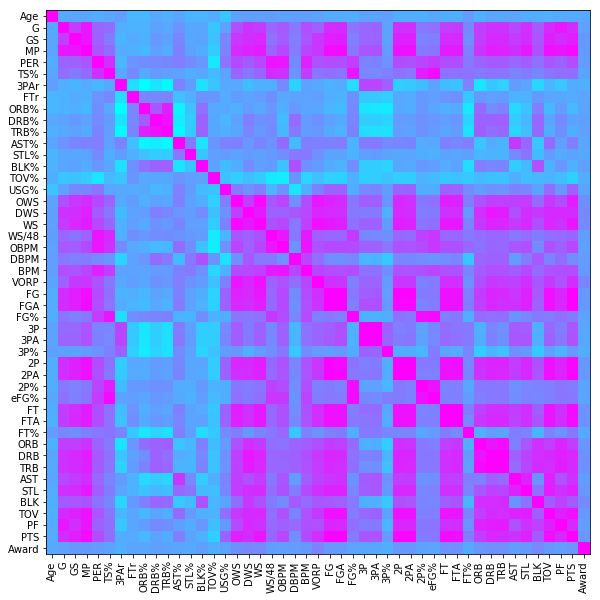

In [181]:
#fig, ax = plt.subplots(figsize=(13,13))
#plt.matshow(corr)
names = corr.axes[0].tolist()
plt.rcParams["figure.figsize"] = (10,10)
plt.xticks(np.arange(len(names)),names,rotation=90)
plt.yticks(np.arange(len(names)),names)
#ax.set_xticklabels(corr.axes[0].tolist())
#ax.set_yticklabels(corr.axes[0].tolist())
plt.imshow(corr, cmap='cool',interpolation="nearest")

In [182]:
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

In [201]:
from sklearn.model_selection import train_test_split

In [202]:
data_set_for_model = pd.read_csv("NBA_all_players.csv")

In [203]:
data_set_for_model = data_set_for_model.fillna(0)

In [204]:
working_set_model = data_set_for_model.drop(columns = ['SeasonStart', 'PlayerName', 'Tm', 'blanl', 'blank2'])

In [205]:
working_set_model.columns

Index(['Age', 'G', 'GS', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS',
       'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Award'],
      dtype='object')

In [206]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    dataset.drop(colname, axis=1) # deleting the column from the dataset

In [207]:
correlation(working_set_model, 0.95)

In [219]:
working_set_model.shape

(18578, 47)

In [209]:
X = working_set_model.drop('Award', axis=1)
y = working_set_model['Award']

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [211]:
from sklearn.svm import SVC

In [212]:
svclassifier = SVC(kernel='linear')

In [213]:
svclassifier.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [214]:
y_pred = svclassifier.predict(X_test)

In [215]:
from sklearn.metrics import classification_report, confusion_matrix

In [217]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[3701    1    2]
 [   5    2    0]
 [   4    0    1]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3704
          1       0.67      0.29      0.40         7
          2       0.33      0.20      0.25         5

avg / total       1.00      1.00      1.00      3716



In [218]:
svclassifier.score(X_test, y_test)

0.9967707212055974